In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import os
from pathlib import Path
from typing import List, Dict, Tuple, Any, Optional
import math
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from torchvision import transforms, models
import logging
from tqdm import tqdm
import shutil
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Собранный пайплайн

INFO:__main__:Using device: cpu
INFO:__main__:Загрузка модели для выравнивания лиц...
INFO:__main__:Загрузка ArcFace модели...


ИНИЦИАЛИЗАЦИЯ ПАЙПЛАЙНА РАСПОЗНАВАНИЯ ЛИЦ


INFO:__main__:Инициализация детектора лиц...
INFO:__main__:Пайплайн инициализирован успешно!
INFO:__main__:Сравнение изображений:
INFO:__main__:  Image 1: beatls2.jpg
INFO:__main__:  Image 2: pol.jpg.



СРАВНЕНИЕ ДВУХ ИЗОБРАЖЕНИЙ


INFO:__main__:Найдено лиц:
INFO:__main__:  Image 1: 4 лиц
INFO:__main__:  Image 2: 1 лиц
INFO:__main__:
Сравнение лиц:
INFO:__main__:  Лицо 1 (Image 1) vs Лицо 1 (Image 2)
INFO:__main__:  Косинусное сходство: 0.297
INFO:__main__:  Вероятность того же человека: 64.9%
INFO:__main__:
Сравнение лиц:
INFO:__main__:  Лицо 2 (Image 1) vs Лицо 1 (Image 2)
INFO:__main__:  Косинусное сходство: 0.352
INFO:__main__:  Вероятность того же человека: 67.6%
INFO:__main__:
Сравнение лиц:
INFO:__main__:  Лицо 3 (Image 1) vs Лицо 1 (Image 2)
INFO:__main__:  Косинусное сходство: 0.453
INFO:__main__:  Вероятность того же человека: 72.6%
INFO:__main__:
Сравнение лиц:
INFO:__main__:  Лицо 4 (Image 1) vs Лицо 1 (Image 2)
INFO:__main__:  Косинусное сходство: 0.360
INFO:__main__:  Вероятность того же человека: 68.0%


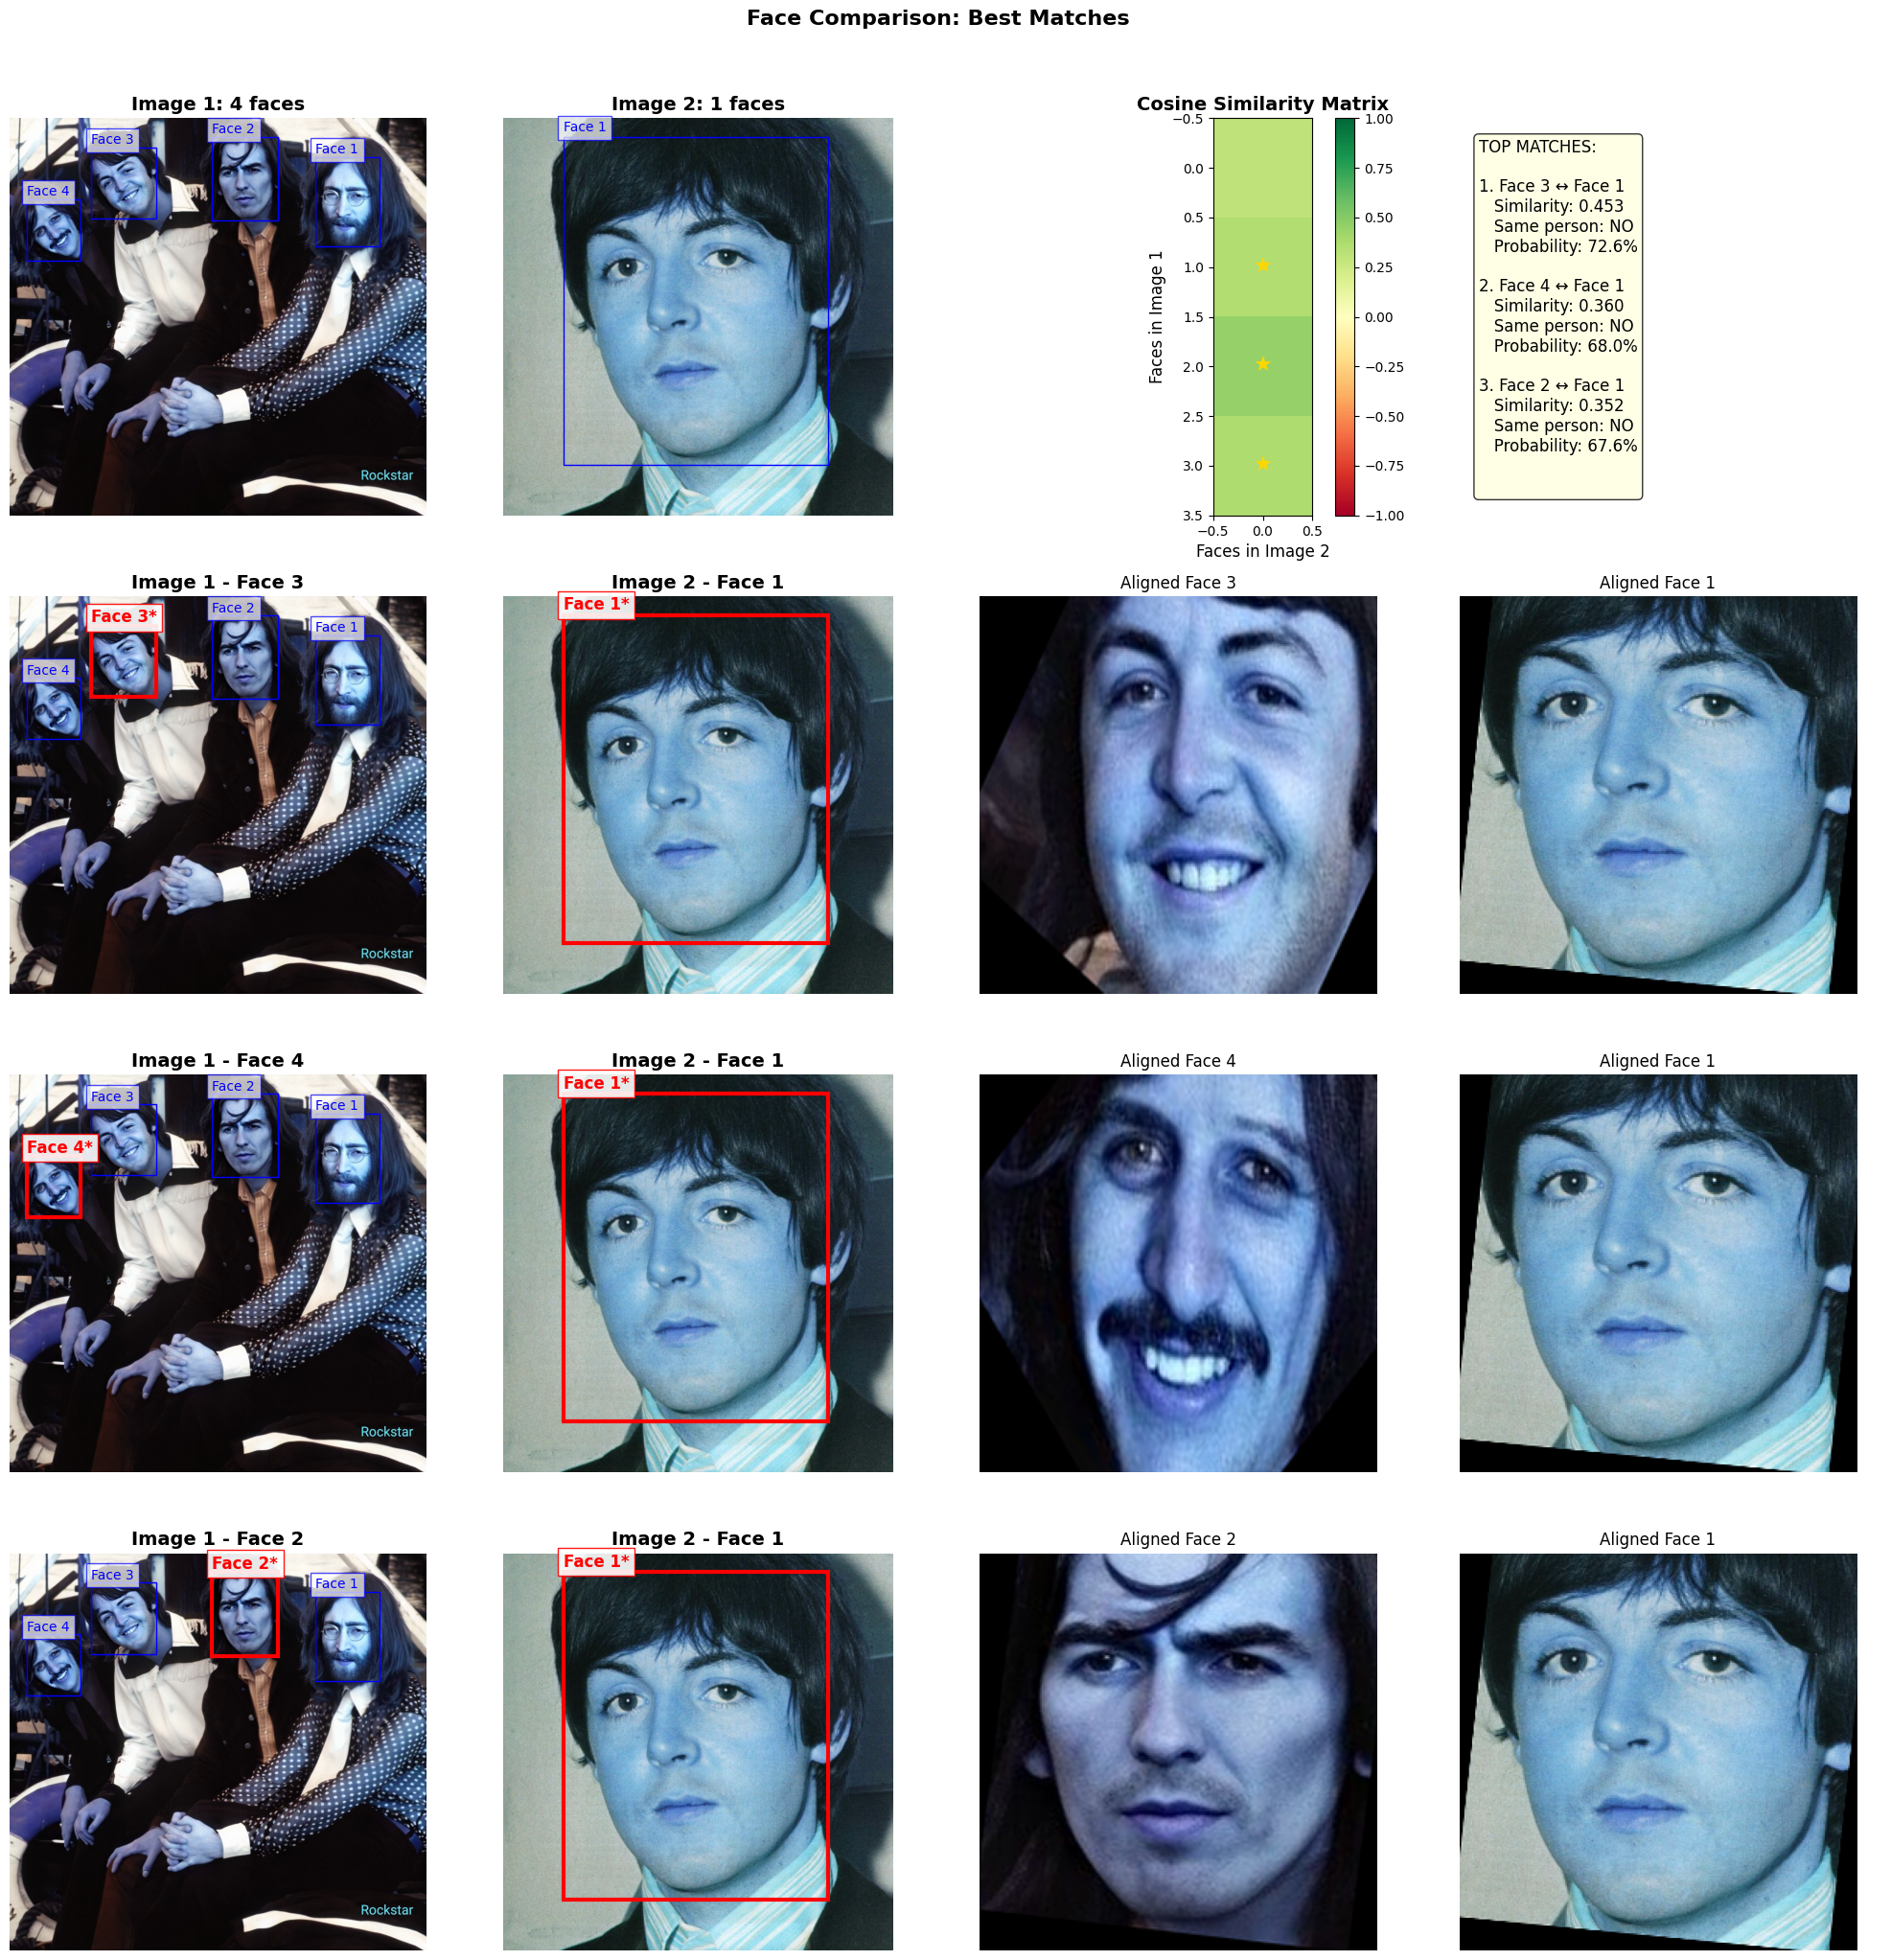


ИТОГОВЫЕ РЕЗУЛЬТАТЫ:

Изображение 1: 4 лиц
Изображение 2: 1 лиц
Всего сравнений: 4

Лучшее совпадение:
  Лицо 3 (Img1) vs Лицо 1 (Img2)
  Косинусное сходство: 0.453
  Вероятность того же человека: 72.6%


In [21]:
# ==================== МОДЕЛЬ ДЛЯ ВЫРАВНИВАНИЯ ЛИЦ ====================

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Sequential()
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)

        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)

        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

class HourglassBlock(nn.Module):
    def __init__(self, depth, channels):
        super().__init__()
        self.depth = depth
        self.channels = channels

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pre_residual = ResidualBlock(channels, channels)

        if depth > 1:
            self.inner_hourglass = HourglassBlock(depth - 1, channels)
        else:
            self.inner_hourglass = ResidualBlock(channels, channels)

        self.post_residual = ResidualBlock(channels, channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        skip = self.pre_residual(x)
        x = self.downsample(skip)
        x = self.inner_hourglass(x)
        x = self.post_residual(x)
        x = self.upsample(x)
        return x + skip

class HeatmapHead(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return x

class StackedHourglassFaceLandmark(nn.Module):
    def __init__(self, n_stacks=2, n_keypoints=5, input_channels=3,
                 hourglass_channels=256, hourglass_depth=4):
        super().__init__()
        self.n_stacks = n_stacks
        self.n_keypoints = n_keypoints

        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(128, 128),
            ResidualBlock(128, hourglass_channels)
        )

        self.hourglasses = nn.ModuleList([
            HourglassBlock(hourglass_depth, hourglass_channels)
            for _ in range(n_stacks)
        ])

        self.heatmap_heads = nn.ModuleList([
            HeatmapHead(hourglass_channels, n_keypoints)
            for _ in range(n_stacks)
        ])

        self.inter_residuals = nn.ModuleList([
            ResidualBlock(hourglass_channels, hourglass_channels)
            for _ in range(n_stacks - 1)
        ])

        self.heatmap_residuals = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(n_keypoints, hourglass_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(hourglass_channels),
                nn.ReLU(inplace=True)
            )
            for _ in range(n_stacks - 1)
        ])

    def forward(self, x):
        x = self.initial_conv(x)
        outputs = []

        for i in range(self.n_stacks):
            hourglass_out = self.hourglasses[i](x)
            heatmap = self.heatmap_heads[i](hourglass_out)
            outputs.append(heatmap)

            if i < self.n_stacks - 1:
                heatmap_residual = self.heatmap_residuals[i](heatmap)
                combined = hourglass_out + heatmap_residual
                x = self.inter_residuals[i](combined)

        return outputs

# ==================== КЛАСС ВЫРАВНИВАНИЯ ЛИЦ ====================

class FaceAligner:
    def __init__(self, model: nn.Module, target_size: int = 256):
        """
        Инициализация выравнивателя лиц

        Args:
            model: Обученная модель для детекции ключевых точек
            target_size: Целевой размер изображения
        """
        self.model = model
        self.target_size = target_size
        self.device = next(model.parameters()).device

    def predict_landmarks(self, image: np.ndarray) -> np.ndarray:
        """
        Предсказание ключевых точек для изображения

        Args:
            image: Изображение в формате BGR

        Returns:
            Массив координат ключевых точек [[x1, y1], ...]
        """
        # Конвертируем BGR в RGB
        if len(image.shape) == 3:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Подготовка для модели
        pil_image = Image.fromarray(image_rgb)
        orig_h, orig_w = image.shape[:2]

        # Трансформации
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        image_tensor = transform(pil_image).unsqueeze(0).to(self.device)

        # Предсказание
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(image_tensor)
            heatmaps = predictions[-1][0].cpu().numpy()

        # Извлечение координат
        landmarks = []
        heatmap_h, heatmap_w = heatmaps.shape[1], heatmaps.shape[2]

        for i in range(heatmaps.shape[0]):
            heatmap = heatmaps[i]
            y_max, x_max = np.unravel_index(heatmap.argmax(), heatmap.shape)

            # Конвертация в оригинальные координаты
            x = x_max * orig_w / heatmap_w
            y = y_max * orig_h / heatmap_h
            landmarks.append([x, y])

        return np.array(landmarks)

    def calculate_rotation_angle(self, left_eye: np.ndarray, right_eye: np.ndarray) -> float:
        """
        Вычисление угла поворота по линии глаз

        Args:
            left_eye: Координаты левого глаза [x, y]
            right_eye: Координаты правого глаза [x, y]

        Returns:
            Угол поворота в градусах
        """
        dy = right_eye[1] - left_eye[1]
        dx = right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dy, dx))
        return angle

    def rotate_image(self, image: np.ndarray, angle: float, center: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Поворот изображения

        Args:
            image: Исходное изображение
            angle: Угол поворота в градусах
            center: Центр вращения (x, y)

        Returns:
            Повернутое изображение и матрица преобразования
        """
        h, w = image.shape[:2]

        # Матрица вращения
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Новые размеры после вращения
        cos_a = abs(np.cos(np.radians(angle)))
        sin_a = abs(np.sin(np.radians(angle)))
        new_w = int(w * cos_a + h * sin_a)
        new_h = int(w * sin_a + h * cos_a)

        # Корректировка матрицы
        M[0, 2] += (new_w - w) / 2
        M[1, 2] += (new_h - h) / 2

        # Применение вращения
        rotated = cv2.warpAffine(
            image, M, (new_w, new_h),
            flags=cv2.INTER_CUBIC,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0, 0, 0)
        )

        return rotated, M

    def calculate_crop_region(self, landmarks: np.ndarray, rotated_landmarks: np.ndarray,
                            image_size: Tuple[int, int]) -> Tuple[int, int, int, int]:
        """
        Вычисление области обрезки для захвата всего лица

        Args:
            landmarks: Ключевые точки
            rotated_landmarks: Ключевые точки после поворота
            image_size: Размер изображения (ширина, высота)

        Returns:
            Координаты области обрезки (x1, y1, x2, y2)
        """
        # Извлекаем точки после поворота
        left_eye = rotated_landmarks[0]
        right_eye = rotated_landmarks[1]
        nose = rotated_landmarks[2]
        left_mouth = rotated_landmarks[3]
        right_mouth = rotated_landmarks[4]

        # Расстояние между глазами
        eye_distance = np.linalg.norm(right_eye - left_eye)

        # Расстояние от глаз до рта
        mouth_y = (left_mouth[1] + right_mouth[1]) / 2
        eyes_y = (left_eye[1] + right_eye[1]) / 2
        eye_to_mouth = abs(mouth_y - eyes_y)

        # Параметры для обрезки
        face_width = int(eye_distance * 3.5)
        face_height = int(eye_to_mouth * 3.0)

        # Центр лица
        face_center_x = nose[0]
        face_center_y = eyes_y + int(eye_to_mouth * 0.8)

        # Область обрезки
        x1 = max(0, int(face_center_x - face_width // 2))
        x2 = min(image_size[0], int(face_center_x + face_width // 2))
        y1 = max(0, int(face_center_y - face_height // 2))
        y2 = min(image_size[1], int(face_center_y + face_height // 2))

        return x1, y1, x2, y2

    def crop_and_resize(self, image: np.ndarray, crop_region: Tuple[int, int, int, int]) -> np.ndarray:
        """
        Обрезка и масштабирование изображения

        Args:
            image: Исходное изображение
            crop_region: Область обрезки (x1, y1, x2, y2)

        Returns:
            Обрезанное и масштабированное изображение
        """
        x1, y1, x2, y2 = crop_region

        # Обрезаем
        cropped = image[y1:y2, x1:x2]

        if cropped.size == 0:
            # Если обрезка пустая, возвращаем исходное изображение
            cropped = image

        # Масштабируем до целевого размера
        resized = cv2.resize(cropped, (self.target_size, self.target_size),
                           interpolation=cv2.INTER_CUBIC)

        return resized

    def align_face_image(self, image: np.ndarray) -> np.ndarray:
        """
        Выравнивание лица на изображении

        Args:
            image: Изображение с лицом

        Returns:
            Выровненное изображение лица
        """
        try:
            # Предсказание ключевых точек
            landmarks = self.predict_landmarks(image)

            # Вычисление угла поворота
            angle = self.calculate_rotation_angle(landmarks[0], landmarks[1])

            # Центр вращения (середина между глазами)
            eye_center = (
                (landmarks[0][0] + landmarks[1][0]) / 2,
                (landmarks[0][1] + landmarks[1][1]) / 2
            )

            # Поворот изображения
            rotated, M = self.rotate_image(image, angle, eye_center)

            # Преобразование ключевых точек
            ones = np.ones((5, 1))
            landmarks_homogeneous = np.hstack([landmarks, ones])
            rotated_landmarks = (M @ landmarks_homogeneous.T).T

            # Вычисление области обрезки
            image_size = (rotated.shape[1], rotated.shape[0])
            crop_region = self.calculate_crop_region(landmarks, rotated_landmarks, image_size)

            # Обрезка и масштабирование
            aligned = self.crop_and_resize(rotated, crop_region)

            return aligned

        except Exception as e:
            logger.error(f"Ошибка при выравнивании лица: {e}")
            # В случае ошибки возвращаем исходное изображение
            return cv2.resize(image, (self.target_size, self.target_size))

# ==================== МОДЕЛЬ ARCFACE ====================

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=32.0, m=0.50):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))

        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

class ArcFaceModel(nn.Module):
    def __init__(self, num_classes=300, embedding_size=512, s=32.0, m=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=False)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.embedding = nn.Sequential(
            nn.Linear(in_features, embedding_size),
            nn.BatchNorm1d(embedding_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        self.arcface = ArcMarginProduct(embedding_size, num_classes, s=s, m=m)

    def forward(self, x, labels=None):
        features = self.backbone(x)
        embeddings = self.embedding(features)

        if labels is not None:
            logits = self.arcface(embeddings, labels)
            return logits, embeddings

        return embeddings

# ==================== ГЛАВНЫЙ ПАЙПЛАЙН ====================

class FaceRecognitionPipeline:
    def __init__(self,
                 landmark_model_path: str,
                 arcface_model_path: str,
                 device: str = 'cuda',
                 detector_type: str = 'mtcnn'):
        """
        Полный пайплайн для распознавания лиц

        Args:
            landmark_model_path: путь к модели для определения ключевых точек
            arcface_model_path: путь к модели ArcFace для эмбеддингов
            device: 'cuda' или 'cpu'
            detector_type: 'mtcnn' или 'haar'
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")

        # 1. Загрузка модели для выравнивания
        logger.info("Загрузка модели для выравнивания лиц...")
        self.face_aligner = self._load_landmark_model(landmark_model_path)

        # 2. Загрузка модели для эмбеддингов
        logger.info("Загрузка ArcFace модели...")
        self.arcface_model = self._load_arcface_model(arcface_model_path)

        # 3. Инициализация детектора лиц
        logger.info("Инициализация детектора лиц...")
        self.detector = self._init_detector(detector_type)
        self.detector_type = detector_type

        # Трансформации для эмбеддингов
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        logger.info("Пайплайн инициализирован успешно!")

    def _load_landmark_model(self, model_path: str) -> FaceAligner:
        """Загрузка модели для выравнивания лиц"""
        checkpoint = torch.load(model_path, map_location=self.device)

        model = StackedHourglassFaceLandmark(
            n_stacks=checkpoint['config']['n_stacks'],
            n_keypoints=5,
            hourglass_channels=checkpoint['config']['hourglass_channels'],
            hourglass_depth=checkpoint['config']['hourglass_depth']
        )

        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(self.device)
        model.eval()

        return FaceAligner(model, target_size=256)

    def _load_arcface_model(self, model_path: str) -> ArcFaceModel:
        """Загрузка ArcFace модели"""
        model = ArcFaceModel(num_classes=350, embedding_size=512, s=32.0, m=0.5)

        checkpoint = torch.load(model_path, map_location=self.device)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)

        model = model.to(self.device)
        model.eval()

        return model

    def _init_detector(self, detector_type: str):
        """Инициализация детектора лиц"""
        if detector_type == 'mtcnn':
            try:
                from facenet_pytorch import MTCNN
                detector = MTCNN(
                    keep_all=True,
                    device=self.device,
                    post_process=False,
                    min_face_size=40
                )
                return detector
            except ImportError:
                logger.warning("MTCNN не установлен. Используем Haar Cascade.")
                detector_type = 'haar'

        if detector_type == 'haar':
            detector = cv2.CascadeClassifier(
                cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
            )
            return detector

        raise ValueError(f"Неизвестный тип детектора: {detector_type}")

    def detect_faces(self, image) -> Tuple[List[Tuple[int, int, int, int]], List[Image.Image]]:
        """
        Детекция лиц на изображении

        Args:
            image: PIL Image или numpy array

        Returns:
            tuple: (список bounding boxes, список изображений лиц)
        """
        # Сохраняем оригинальное изображение
        if isinstance(image, np.ndarray):
            # Если это numpy array от OpenCV, он в BGR
            if len(image.shape) == 3 and image.shape[2] == 3:
                # Сохраняем BGR версию для вырезки
                image_bgr = image
                # Создаем RGB версию для MTCNN
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_pil = Image.fromarray(image_rgb)
            else:
                image_bgr = image
                image_pil = Image.fromarray(image)
        else:
            # Если это PIL Image, он уже в RGB
            image_pil = image
            image_array = np.array(image_pil)
            if len(image_array.shape) == 3 and image_array.shape[2] == 3:
                image_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
            else:
                image_bgr = image_array

        face_images = []
        boxes_list = []

        if self.detector_type == 'mtcnn':
            boxes, probs = self.detector.detect(image_pil)

            if boxes is not None:
                for i, box in enumerate(boxes):
                    if probs[i] > 0.7:  # Порог уверенности
                        x1, y1, x2, y2 = box.astype(int)

                        # Расширяем bounding box на 20%
                        width = x2 - x1
                        height = y2 - y1
                        x1 = max(0, int(x1 - width * 0.1))
                        y1 = max(0, int(y1 - height * 0.1))
                        x2 = min(image_bgr.shape[1], int(x2 + width * 0.1))
                        y2 = min(image_bgr.shape[0], int(y2 + height * 0.1))

                        # Вырезаем лицо из BGR изображения
                        face_crop_bgr = image_bgr[y1:y2, x1:x2]
                        if face_crop_bgr.size > 0:
                            # Конвертируем BGR в RGB для PIL
                            if len(face_crop_bgr.shape) == 3:
                                face_crop_rgb = cv2.cvtColor(face_crop_bgr, cv2.COLOR_BGR2RGB)
                            else:
                                # Если черно-белое, создаем 3-канальное изображение
                                face_crop_rgb = cv2.cvtColor(face_crop_bgr, cv2.COLOR_GRAY2RGB)

                            face_pil = Image.fromarray(face_crop_rgb)
                            face_images.append(face_pil)
                            boxes_list.append((x1, y1, x2, y2))

        else:  # Haar Cascade
            if len(image_bgr.shape) == 3:
                gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
            else:
                gray = image_bgr

            # Детекция лиц
            faces = self.detector.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(40, 40),
                flags=cv2.CASCADE_SCALE_IMAGE
            )

            for (x, y, w, h) in faces:
                # Расширяем bounding box
                x1 = max(0, int(x - w * 0.1))
                y1 = max(0, int(y - h * 0.1))
                x2 = min(image_bgr.shape[1], int(x + w * 1.1))
                y2 = min(image_bgr.shape[0], int(y + h * 1.1))

                # Вырезаем лицо из BGR изображения
                face_crop_bgr = image_bgr[y1:y2, x1:x2]
                if face_crop_bgr.size > 0:
                    # Конвертируем BGR в RGB для PIL
                    if len(face_crop_bgr.shape) == 3:
                        face_crop_rgb = cv2.cvtColor(face_crop_bgr, cv2.COLOR_BGR2RGB)
                    else:
                        face_crop_rgb = cv2.cvtColor(face_crop_bgr, cv2.COLOR_GRAY2RGB)

                    face_pil = Image.fromarray(face_crop_rgb)
                    face_images.append(face_pil)
                    boxes_list.append((x1, y1, x2, y2))

        return boxes_list, face_images

    def align_face(self, face_image: Image.Image) -> Image.Image:
        """
        Выравнивание лица по ключевым точкам

        Args:
            face_image: изображение лица (PIL Image)

        Returns:
            выравненное изображение лица (PIL Image)
        """
        # Конвертируем PIL Image в numpy array
        face_np = np.array(face_image)

        # Если изображение в RGB, конвертируем в BGR для OpenCV
        if len(face_np.shape) == 3:
            face_np = cv2.cvtColor(face_np, cv2.COLOR_RGB2BGR)

        # Выравниваем лицо
        aligned_face = self.face_aligner.align_face_image(face_np)

        # Конвертируем обратно в RGB для PIL
        if len(aligned_face.shape) == 3:
            aligned_face_rgb = cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB)
        else:
            # Если черно-белое изображение
            aligned_face_rgb = aligned_face
        return Image.fromarray(aligned_face_rgb)

    def get_embeddings(self, face_images: List[Image.Image]) -> np.ndarray:
        """
        Получение эмбеддингов для списка лиц

        Args:
            face_images: список PIL Images лиц

        Returns:
            numpy array: массив эмбеддингов (n_faces x embedding_size)
        """
        if not face_images:
            return np.array([])

        # Подготавливаем батч
        batch = []
        for face_img in face_images:
            transformed = self.transform(face_img)
            batch.append(transformed)

        batch_tensor = torch.stack(batch).to(self.device)

        # Получаем эмбеддинги
        with torch.no_grad():
            embeddings = self.arcface_model(batch_tensor)
            embeddings = F.normalize(embeddings, p=2, dim=1)

        return embeddings.cpu().numpy()

    def process_image(self, image_path: str) -> Tuple[np.ndarray, List[Tuple[int, int, int, int]], List[Image.Image], np.ndarray]:
        """
        Полная обработка одного изображения

        Args:
            image_path: путь к изображению

        Returns:
            tuple: (исходное изображение, bounding boxes, выравненные лица, эмбеддинги)
        """
        # Загружаем изображение
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Не удалось загрузить изображение: {image_path}")

        # Детекция лиц
        boxes, face_images = self.detect_faces(image)

        if not face_images:
            logger.warning(f"На изображении {image_path} не найдено лиц")
            return image, [], [], np.array([])

        # Выравнивание лиц
        aligned_faces = []
        for face_img in face_images:
            aligned_face = self.align_face(face_img)
            aligned_faces.append(aligned_face)

        # Получение эмбеддингов
        embeddings = self.get_embeddings(aligned_faces)

        return image, boxes, aligned_faces, embeddings

    def compare_two_images(self,
                          image1_path: str,
                          image2_path: str,
                          visualize: bool = True) -> Dict[str, Any]:
        """
        Сравнение лиц на двух изображениях

        Args:
            image1_path: путь к первому изображению
            image2_path: путь ко второму изображению
            visualize: показывать ли визуализацию

        Returns:
            dict: результаты сравнения
        """
        logger.info(f"Сравнение изображений:")
        logger.info(f"  Image 1: {image1_path}")
        logger.info(f"  Image 2: {image2_path}")

        # Обрабатываем оба изображения
        image1, boxes1, aligned_faces1, embeddings1 = self.process_image(image1_path)
        image2, boxes2, aligned_faces2, embeddings2 = self.process_image(image2_path)

        logger.info(f"Найдено лиц:")
        logger.info(f"  Image 1: {len(boxes1)} лиц")
        logger.info(f"  Image 2: {len(boxes2)} лиц")

        results = {
            'image1': {
                'path': image1_path,
                'faces_count': len(boxes1),
                'boxes': boxes1,
                'embeddings': embeddings1
            },
            'image2': {
                'path': image2_path,
                'faces_count': len(boxes2),
                'boxes': boxes2,
                'embeddings': embeddings2
            },
            'comparisons': []
        }

        # Сравниваем эмбеддинги
        if len(embeddings1) > 0 and len(embeddings2) > 0:
            # Вычисляем матрицу косинусных сходств
            cos_sim_matrix = np.dot(embeddings1, embeddings2.T)

            # Для каждой пары лиц
            for i in range(len(embeddings1)):
                for j in range(len(embeddings2)):
                    cos_sim = float(cos_sim_matrix[i, j])
                    euclidean_dist = np.linalg.norm(embeddings1[i] - embeddings2[j])

                    comparison = {
                        'face1_idx': i,
                        'face2_idx': j,
                        'cosine_similarity': cos_sim,
                        'euclidean_distance': euclidean_dist,
                        'same_person_probability': max(0, min(1, (cos_sim + 1) / 2)),
                        'is_same_person': cos_sim > 0.5  # Порог можно настроить
                    }

                    results['comparisons'].append(comparison)

                    logger.info(f"\nСравнение лиц:")
                    logger.info(f"  Лицо {i+1} (Image 1) vs Лицо {j+1} (Image 2)")
                    logger.info(f"  Косинусное сходство: {cos_sim:.3f}")
                    logger.info(f"  Вероятность того же человека: {comparison['same_person_probability']:.1%}")


        # Визуализация
        if visualize and (len(boxes1) > 0 or len(boxes2) > 0):
            self._visualize_comparison(
                image1, boxes1, aligned_faces1, embeddings1,
                image2, boxes2, aligned_faces2, embeddings2,
                results['comparisons']
            )

        return results

    def _visualize_comparison(self,
                             image1: np.ndarray, boxes1: List, aligned_faces1: List, embeddings1: np.ndarray,
                             image2: np.ndarray, boxes2: List, aligned_faces2: List, embeddings2: np.ndarray,
                             comparisons: List[Dict]):
        """Визуализация сравнения двух изображений с выделением пар с наибольшим сходством"""

        def fix_colors_for_display(image_array):
            """Исправление цветов для корректного отображения"""
            if len(image_array.shape) == 3 and image_array.shape[2] == 3:
                # Проверяем, нужно ли конвертировать из BGR в RGB
                if image_array[:, :, 0].mean() > image_array[:, :, 2].mean():
                    return cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
            return image_array

        # Сортируем сравнения по сходству (от большего к меньшему)
        sorted_comparisons = sorted(comparisons, key=lambda x: x['cosine_similarity'], reverse=True)

        if not comparisons:
            print("Нет пар для сравнения")
            return

        # Берем топ-3 пары с наибольшим сходством
        top_matches = sorted_comparisons[:min(3, len(sorted_comparisons))]

        # Создаем фигуру с несколькими рядами
        n_rows = len(top_matches) + 1  # +1 для оригинальных изображений
        fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows))

        # Если только один ряд, делаем axes двумерным
        if n_rows == 1:
            axes = axes.reshape(1, -1)

        # Функция для отображения изображения с bounding boxes
        def plot_image(ax, image, boxes, title, highlight_boxes=None):
            display_img = fix_colors_for_display(image)
            ax.imshow(display_img)

            if highlight_boxes is None:
                highlight_boxes = []

            for i, (x1, y1, x2, y2) in enumerate(boxes):
                # Выбираем цвет: красный для выделенных боксов, синий для остальных
                if i in highlight_boxes:
                    color = 'red'
                    linewidth = 3
                else:
                    color = 'blue'
                    linewidth = 1

                rect = Rectangle((x1, y1), x2-x1, y2-y1,
                               linewidth=linewidth, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                if i in highlight_boxes:
                    ax.text(x1, y1-10, f'Face {i+1}*',
                           color='red', fontsize=12, fontweight='bold',
                           bbox=dict(facecolor='white', alpha=0.9, edgecolor='red'))
                else:
                    ax.text(x1, y1-10, f'Face {i+1}',
                           color='blue', fontsize=10,
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='blue'))

            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.axis('off')

        # 1. Ряд: Оригинальные изображения со всеми лицами
        plot_image(axes[0, 0], image1, boxes1, f'Image 1: {len(boxes1)} faces')
        plot_image(axes[0, 1], image2, boxes2, f'Image 2: {len(boxes2)} faces')

        # Матрица сходства
        if len(embeddings1) > 0 and len(embeddings2) > 0:
            cos_sim_matrix = np.dot(embeddings1, embeddings2.T)
            im = axes[0, 2].imshow(cos_sim_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
            axes[0, 2].set_title('Cosine Similarity Matrix', fontsize=14, fontweight='bold')
            axes[0, 2].set_xlabel('Faces in Image 2', fontsize=12)
            axes[0, 2].set_ylabel('Faces in Image 1', fontsize=12)
            plt.colorbar(im, ax=axes[0, 2])

            # Подсвечиваем лучшие совпадения на матрице
            for match in top_matches:
                axes[0, 2].text(match['face2_idx'], match['face1_idx'], '★',
                              ha="center", va="center",
                              color="gold", fontsize=16, fontweight='bold')

        # Информация о сравнениях
        axes[0, 3].axis('off')
        info_text = "TOP MATCHES:\n\n"
        for i, match in enumerate(top_matches, 1):
            info_text += f"{i}. Face {match['face1_idx']+1} ↔ Face {match['face2_idx']+1}\n"
            info_text += f"   Similarity: {match['cosine_similarity']:.3f}\n"
            info_text += f"   Same person: {'YES' if match['is_same_person'] else 'NO'}\n"
            info_text += f"   Probability: {match['same_person_probability']:.1%}\n\n"

        axes[0, 3].text(0.1, 0.5, info_text, fontsize=12,
                       verticalalignment='center', transform=axes[0, 3].transAxes,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))

        # 2+. Ряды: Пары с наибольшим сходством
        for row_idx, match in enumerate(top_matches, 1):
            face1_idx = match['face1_idx']
            face2_idx = match['face2_idx']

            # Подсвечиваем соответствующие лица на оригинальных изображениях
            plot_image(axes[row_idx, 0], image1, boxes1,
                      f'Image 1 - Face {face1_idx+1}', [face1_idx])

            plot_image(axes[row_idx, 1], image2, boxes2,
                      f'Image 2 - Face {face2_idx+1}', [face2_idx])

            # Выравненные лица
            if face1_idx < len(aligned_faces1):
                aligned_face1_np = np.array(aligned_faces1[face1_idx])
                aligned_face1_np = fix_colors_for_display(aligned_face1_np)
                axes[row_idx, 2].imshow(aligned_face1_np)
                axes[row_idx, 2].set_title(f'Aligned Face {face1_idx+1}', fontsize=12)
                axes[row_idx, 2].axis('off')

            if face2_idx < len(aligned_faces2):
                aligned_face2_np = np.array(aligned_faces2[face2_idx])
                aligned_face2_np = fix_colors_for_display(aligned_face2_np)
                axes[row_idx, 3].imshow(aligned_face2_np)
                axes[row_idx, 3].set_title(f'Aligned Face {face2_idx+1}', fontsize=12)
                axes[row_idx, 3].axis('off')

        plt.suptitle(f'Face Comparison: Best Matches', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()


# ==================== ПРИМЕР ИСПОЛЬЗОВАНИЯ ====================

def main():
    """Пример использования пайплайна"""

    # Пути к моделям (замените на ваши реальные пути)
    LANDMARK_MODEL_PATH = 'simple_models/simple_face_landmark_best.pth'
    ARCFACE_MODEL_PATH = 'checkpoints/best_model_arcface.pth'

    # Пути к тестовым изображениям
    IMAGE1_PATH = 'beatls2.jpg'
    IMAGE2_PATH = 'pol.jpg.'

    # Проверка существования файлов
    for path in [LANDMARK_MODEL_PATH, ARCFACE_MODEL_PATH, IMAGE1_PATH, IMAGE2_PATH]:
        if not os.path.exists(path):
            logger.warning(f"Файл не найден: {path}")

    # Инициализация пайплайна
    print("="*60)
    print("ИНИЦИАЛИЗАЦИЯ ПАЙПЛАЙНА РАСПОЗНАВАНИЯ ЛИЦ")
    print("="*60)

    try:
        pipeline = FaceRecognitionPipeline(
            landmark_model_path=LANDMARK_MODEL_PATH,
            arcface_model_path=ARCFACE_MODEL_PATH,
            device='cuda',  # Использовать 'cpu' если нет GPU
            detector_type='mtcnn'  # или 'haar'
        )
    except Exception as e:
        logger.error(f"Ошибка при инициализации пайплайна: {e}")
        return

    # Сравнение двух изображений
    print("\n" + "="*60)
    print("СРАВНЕНИЕ ДВУХ ИЗОБРАЖЕНИЙ")
    print("="*60)

    try:
        results = pipeline.compare_two_images(
            image1_path=IMAGE1_PATH,
            image2_path=IMAGE2_PATH,
            visualize=True
        )

        # Вывод итоговых результатов
        print("\n" + "="*60)
        print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ:")
        print("="*60)

        print(f"\nИзображение 1: {results['image1']['faces_count']} лиц")
        print(f"Изображение 2: {results['image2']['faces_count']} лиц")
        print(f"Всего сравнений: {len(results['comparisons'])}")

        if results['comparisons']:
            # Находим пару с максимальным сходством
            best_match = max(results['comparisons'], key=lambda x: x['cosine_similarity'])
            print(f"\nЛучшее совпадение:")
            print(f"  Лицо {best_match['face1_idx']+1} (Img1) vs Лицо {best_match['face2_idx']+1} (Img2)")
            print(f"  Косинусное сходство: {best_match['cosine_similarity']:.3f}")
            print(f"  Вероятность того же человека: {best_match['same_person_probability']:.1%}")

    except Exception as e:
        logger.error(f"Ошибка при сравнении изображений: {e}")

if __name__ == "__main__":
    main()